In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from experiment_train import *
from experiment_datasets import *
from helpers import *
import matplotlib
from matplotlib.patches import Patch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# network configuration
N = [100, 50]

def get_p_arr(p):
    """ p array with failure on the first layer """
    return [0, p]  + [0] * len(N)

# prob. of failure at inference
p_inf = 0.05
p_inference = get_p_arr(p_inf)

# prob. of failure at train
p_trains = np.linspace(0, 1.2 * p_inf, 10)

# Lips. coeff
KLips = 1.

# activation function
activation = 'sigmoid'

# number of repeats for error estimation
# see below for explanation
repetitions = 6

# number of runs for each p
runs = 10

In [7]:
def get_results(p):
    # obtaining the distribution after 10 epochs
    results = []
    
    # current prob. of failure array
    p_train = get_p_arr(p)
    
    def unravel(name, data):
        return {name + '_' + key: data[key] for key in data.keys()}
    
    for _ in tqdm(range(runs)):
        exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = p_train, KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)
        
        results += [{**unravel('correct_acc', exp.get_accuracy_correct()), # test_only = True
                     **unravel('crashing_acc', exp.get_accuracy_crash(repetitions = repetitions)), # test_only = True
                     
                     **unravel('correct_mae', exp.get_mae_correct()),
                     **unravel('crashing_mae', exp.get_mae_crash(repetitions = repetitions)),
                     
                     'v2_var': np.mean(exp.get_bound_v2(exp.x_train)['std'] ** 2),
                     'v2_mean': np.mean(exp.get_bound_v2(exp.x_train)['mean']),
                     
                     'v3_var': np.mean(exp.get_bound_v3(exp.x_train)['std'] ** 2),
                     'v3_mean': np.mean(exp.get_bound_v3(exp.x_train)['mean']),
                               
                     'v4_var': np.mean(exp.get_bound_v4(exp.x_train)['std'] ** 2),
                     'v4_mean': np.mean(exp.get_bound_v4(exp.x_train)['mean']),
                     
                     'v1_infnorm_mean': np.mean(exp.get_bound_v1_infnorm(exp.x_train)['mean']),
                    }]
        
        # freeing up the memory
        K.clear_session()
        
    # list of all keys
    keys = list(results[0].keys())
    
    # return results
    return {key: [value[key] for value in results] for key in keys}

def process_results_single(results):
    for key, value in results.items():
        plt.figure()
        plt.title('%s: %.3f +- %.3f med %.3f' % (key, np.mean(value), np.std(value), np.median(value)))
        plt.hist(value)
        plt.xlabel(key)
        plt.show()

In [4]:
exp = MNISTExperiment(N = N, p_inference = p_inference, p_train = get_p_arr(0.01), KLips = KLips, epochs = 10,
                                      activation = activation, reg_type = None, reg_coeff = 0, do_print = False,
                                      name = 'experiment_dropout', seed = None, batch_size = 100)

In [5]:
# array of repetitions values
rs = np.arange(10)[1:]

In [6]:
# obtaining accuracy for each repetition parameter
results = [exp.get_accuracy_crash(repetitions = r) for r in tqdm(rs)]

100%|██████████| 9/9 [00:36<00:00,  4.06s/it]


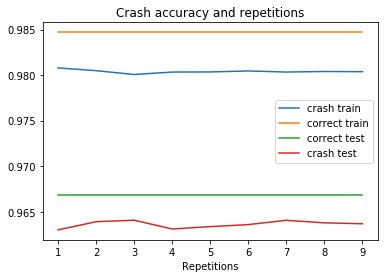

In [8]:
plt.figure()
plt.title('Crash accuracy and repetitions')
plt.plot(rs, [x['train'] for x in results], label = 'crash train')
plt.plot(rs, [exp.get_accuracy_correct()['train']] * len(rs), label = 'correct train')
plt.plot(rs, [exp.get_accuracy_correct()['test']] * len(rs), label = 'correct test')
plt.plot(rs, [x['test'] for x in results], label = 'crash test')
plt.xlabel('Repetitions')
plt.legend()
plt.show()

In [11]:
# obtaining accuracy for each repetition parameter
results = [exp.get_mae_crash(repetitions = r) for r in tqdm(rs)]

100%|██████████| 9/9 [00:35<00:00,  5.17s/it]


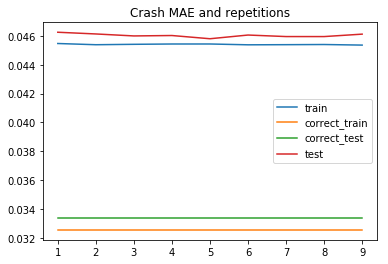

In [14]:
plt.figure()
plt.title('Crash MAE and repetitions')
plt.plot(rs, [x['train'] for x in results], label = 'train')
plt.plot(rs, [exp.get_mae_correct()['train']] * len(rs), label = 'correct_train')
plt.plot(rs, [exp.get_mae_correct()['test']] * len(rs), label = 'correct_test')
plt.plot(rs, [x['test'] for x in results], label = 'test')
plt.legend()
plt.show()

In [4]:
# 6 repetitions of the dataset is enough

In [4]:
# obtaining results
results_array = [get_results(p) for p in p_trains]

100%|██████████| 10/10 [04:29<00:00, 27.31s/it]


In [8]:
save_fn = 'ComparisonIncreasingDropoutMNIST.ipynb.pkl'
#pickle.dump(results_array, open(save_fn, 'wb'))
results_array = pickle.load(open(save_fn, 'rb'))

In [9]:
font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

In [10]:
def plot_quantity(results_array, name, axis = plt, style = '-', **kwargs):
    """ Plot mean and variance of a quantity in results_array with name """
    means = np.array([np.mean(r[name]) for r in results_array])
    stds  = [np.std(r[name]) for r in results_array]
    if name.startswith('v'):
        name = 'b' + name[1:]
    axis.plot(p_trains, means, style, label = name, **kwargs)
    axis.fill_between(p_trains, means - stds, means + stds, alpha = 0.5, **kwargs)

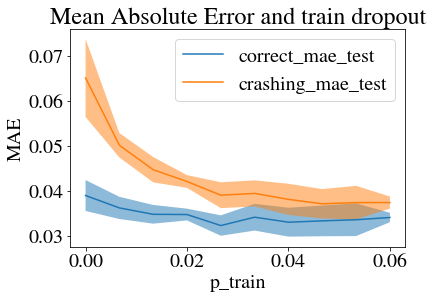

In [11]:
# it also decays for train
plt.figure()
plt.title('Mean Absolute Error and train dropout')
plot_quantity(results_array, 'correct_mae_test')
plot_quantity(results_array, 'crashing_mae_test')
#plot_quantity(results_array, 'correct_mae_train')
#plot_quantity(results_array, 'crashing_mae_train')
plt.xlabel('p_train')
plt.ylabel('MAE')
plt.legend()
plt.savefig('figures/comparison_mae_do_mnist.pdf', bbox_inches = 'tight')
plt.savefig('figures/comparison_mae_do_mnist.png', bbox_inches = 'tight')
plt.show()

<Figure size 432x288 with 0 Axes>

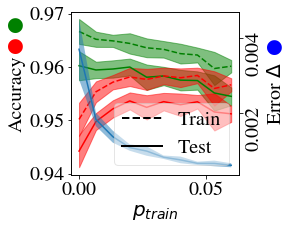

In [12]:
# it also behaves the same for train
plt.figure()

fig, ax1 = plt.subplots(figsize=(3, 3))

#plt.title('Accuracy over the dataset and train dropout')
plot_quantity(results_array, 'correct_acc_test', color = 'green', axis = ax1)
plot_quantity(results_array, 'crashing_acc_test', color = 'red', axis = ax1)
plot_quantity(results_array, 'correct_acc_train', color = 'green', style = '--',  axis = ax1)
plot_quantity(results_array, 'crashing_acc_train', color = 'red', style = '--', axis = ax1)

ax2 = ax1.twinx()
#ax3 = ax1.twinx()
#ax4 = ax1.twinx()
ax2.set_ylabel('Error $\Delta$')
plot_quantity(results_array, 'v3_var', axis = ax2)
# https://stackoverflow.com/questions/43152502/how-can-i-rotate-xticklabels-in-matplotlib-so-that-the-spacing-between-each-xtic/43153984
for label in ax2.get_yticklabels():
    label.set_rotation(90)
#plot_quantity(results_array, 'v4_var', axis = ax2)
ax1.set_xlabel('$p_{train}$')
ax1.set_ylabel('Accuracy')
#ax1.legend()
#ax2.legend()

#plt.savefig('figures/comparison_acc_do_mnist.png', bbox_inches = 'tight')
ax1.text(-0.025, 0.962,'●', color = 'red',ha="center", va="bottom")
ax1.text(-0.025, 0.966,'●', color = 'green',ha="center", va="bottom")
ax2.text(0.077, 0.0035,'●', color = 'blue',ha="center", va="bottom")

legend_elements = [plt.Line2D([0], [0], linestyle = '--', color='black', lw=2, label='Train'),
                   plt.Line2D([0], [0], linestyle = '-', color='black', lw=2, label='Test'),
                   ]
plt.legend(handles=legend_elements, loc='lower right', framealpha = 0.5)
plt.savefig('figures/comparison_acc_do_mnist.pdf', bbox_inches = 'tight')
plt.show()

Choosing p_train = 0.02 results in increase in crashing accuracy by 1% but almost no decrease in correct accuracy

In [13]:
# threshold for p_train
threshold = 0.03

def get_rank_loss(results_array, key):
    def allvalues(array, key, threshold = threshold):
        """ Array of values with same key """
        return [entry[key] for i, entry in enumerate(array) if p_trains[i] <= threshold]
    
    # values for key
    values = allvalues(results_array, key)
    
    # number of p settings
    bins  = len(values)
    
    # number of networks for each p
    inbin = len(values[0])
    
    # resulting yes/no array
    result = []
    
    # loops over bind
    for bin1 in range(bins):
        for bin2 in range(bins):
            # bin1 < bin2
            if bin1 >= bin2: continue
                
            # loops inside the bin
            for elem1 in range(inbin):
                for elem2 in range(inbin):
                    # comparing v1 and v2
                    value1 = values[bin1][elem1]
                    value2 = values[bin2][elem2]
                    result += [value1 < value2]
                    
    # result: number of incorrectly ordered pairs
    value = np.mean(result)
    return min(value, 1 - value)

In [14]:
# all keys
keys = results_array[0].keys()

# all losses
losses = {key: get_rank_loss(results_array, key) for key in keys}
keys = sorted(keys, key = lambda x : losses[x])

In [22]:
# rank loss with dropout increase
df = pd.DataFrame([(key, losses[key]) for key in keys], columns = ['Key', 'Rank Loss'])
df

,Key,Rank Loss
0,v4_var,0.031
1,v3_var,0.036
2,crashing_mae_train,0.056
3,crashing_mae_test,0.056
4,crashing_acc_test,0.177
5,crashing_acc_train,0.198
6,correct_mae_test,0.220
7,correct_mae_train,0.233
8,v2_mean,0.248
9,correct_acc_train,0.317


In [34]:
print(df.to_latex(columns = ['Key', 'Rank Loss'], index = False))

\begin{tabular}{lr}
\toprule
                Key &  Rank Loss \\
\midrule
             v4\_var &      0.031 \\
             v3\_var &      0.036 \\
 crashing\_mae\_train &      0.056 \\
  crashing\_mae\_test &      0.056 \\
  crashing\_acc\_test &      0.177 \\
 crashing\_acc\_train &      0.198 \\
   correct\_mae\_test &      0.220 \\
  correct\_mae\_train &      0.233 \\
            v2\_mean &      0.248 \\
  correct\_acc\_train &      0.317 \\
             v2\_var &      0.317 \\
   correct\_acc\_test &      0.399 \\
            v3\_mean &      0.408 \\
            v4\_mean &      0.462 \\
\bottomrule
\end{tabular}



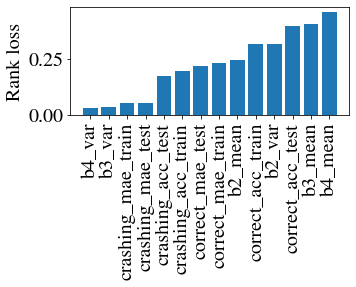

In [16]:
plt.figure(figsize=(5,2))
#plt.title('Bound comparison for dropout on train')
plt.ylabel('Rank loss')
keys_proc = ['b' + key[1:] if key.startswith('v') else key for key in keys]
plt.bar(keys_proc, [losses[x] for x in keys])
plt.xticks(rotation=90)
plt.savefig('figures/comparison_do_mnist.pdf', bbox_inches = 'tight')
#plt.savefig('figures/comparison_do_mnist.png', bbox_inches = 'tight')
plt.show()

In [17]:
# renaming entities to match the new paper
# None means do not show
def shorten(t):
    def shorten_one(x):
        z = {'train': '@', 'test': '#', 'acc': 'a', 'mae': 'm', 'correct': '+', 'crashing': '!'}
        if x in z: return z[x]
        return x
    return ''.join([shorten_one(x) for x in t.split('_')])
keys_rename = {key: shorten(key) for key in keys}
keys_rename.update({'v4_var': None, 'v4_mean': None,
                    'v3_var': "v p5",
                    'v3_mean': "e p5",
                    'v2_mean': "e p2",
                    'v2_var': "v p2",
              })
def get_color(field):
    if field.find('crashing') >= 0:
        return 'red'
    if field.find('correct') >= 0:
        return 'green'
    if field.startswith('v') and field.endswith('var'):
        return 'blue'
    return 'yellow'
def get_style(field):
    if field.find('train') >= 0:
        return '/////'
    if field.find('test') >= 0:
        return "\\\\\\\\\\"
    return ''
#patterns = ('-', '+', 'x', '\\', '*', 'o', 'O', '.')

In [18]:
font = {'family' : 'STIXGeneral',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

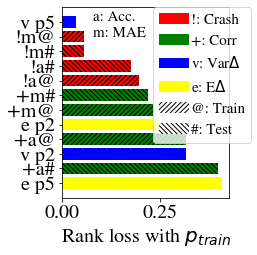

In [19]:
plt.figure(figsize=(3,3.5))
#plt.title('Bound comparison for dropout on train')
plt.xlabel('Rank loss with $p_{train}$')
keys_show = [x for x in keys[::-1] if keys_rename[x] is not None]
colors = [get_color(x) for x in keys_show]
styles = [get_style(x) for x in keys_show]
keys_renamed = [keys_rename[x] for x in keys_show]
bars = plt.barh(keys_renamed, [losses[x] for x in keys_show], color = colors)
for bar, pattern in zip(bars, styles):
    bar.set_hatch(pattern)
#plt.xticks(rotation=90)

legend_elements = [Patch(facecolor='red'),
                  Patch(facecolor='green'),
                  Patch(facecolor='blue'),
                  Patch(facecolor='yellow'),
                  Patch(facecolor = 'white', hatch = '/////'),
                  Patch(facecolor = 'white', hatch = '\\\\\\\\\\'),]
plt.legend(legend_elements, ['!: Crash', '+: Corr', 'v: Var$\Delta$', 'e: E$\Delta$', '@: Train', '#: Test'],
           ncol=1,  bbox_to_anchor=(0.5,0.25), fontsize = 15, handletextpad=0.1)
plt.text(0.08, 10, "a: Acc.\nm: MAE", fontsize=15)
plt.savefig('figures/comparison_do_mnist.svg', bbox_inches = 'tight')
plt.show()

In [20]:
!rsvg-convert -f pdf -o figures/comparison_do_mnist.pdf figures/comparison_do_mnist.svg